In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder , LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, roc_auc_score , accuracy_score , precision_score, recall_score, f1_score, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Models
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier ,StackingClassifier
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC


# Imbalanced-learn for handling class imbalance correctly in pipelines
from imblearn.pipeline import Pipeline as ImbPipeline

# Model Explainability
import shap

# Configure settings for cleaner output
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')


c:\Users\PC\BankMarketing\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/eda_data.csv' )
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.shape

(39404, 20)

In [4]:
# Mapping dictionary
mapping = {"yes": 1, "no": 0}

# Apply mapping to train, validate, and test

df['y'] = df['y'].map(mapping)


In [5]:
X = df.drop(columns=['y'],axis=1)
y = df['y']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: y, dtype: int64

In [6]:
# Stratified split ensures the proportion of the target class is the same across all sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)
X_validate, X_test, y_validate, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_validate.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (27582, 19)
Validation set shape: (5911, 19)
Test set shape: (5911, 19)


#### Finding best bins from training data so can data leakage not occure

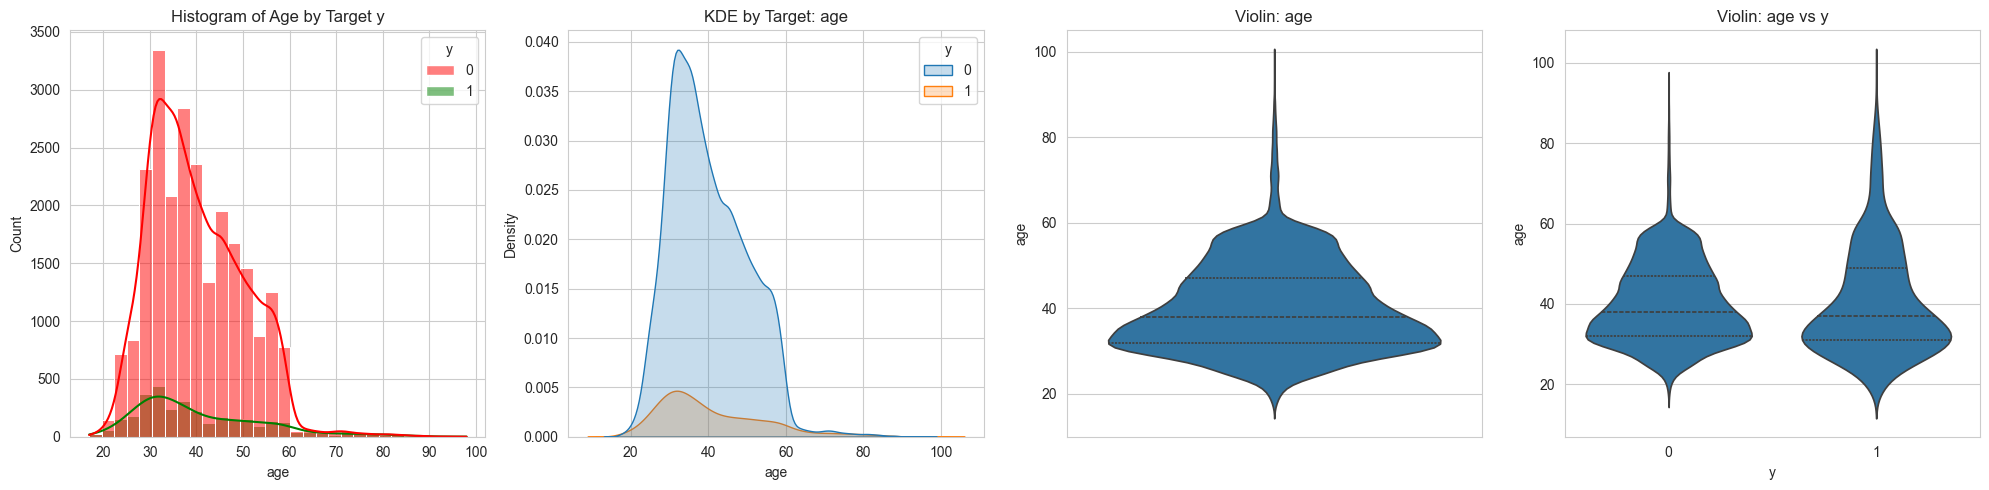

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))  # 1 row, 4 columns

# 1. Combine X_train and y_train into one DataFrame for plotting
X_plot = X_train.copy()
X_plot['y'] = y_train  # Add target column

sns.histplot(
    data=X_plot,
    x='age',
    hue='y',            # split by yes/no
    bins=30,
    kde=True,
    palette={1:'green', 0:'red'},  # custom colors
    alpha=0.5,          # transparency for overlap
    ax=axes[0]
)
axes[0].set_title(f'Histogram of Age by Target y')

sns.kdeplot(data=X_plot, x='age', hue='y', fill=True, ax=axes[1])
axes[1].set_title(f'KDE by Target: age')

sns.violinplot(y='age',data=X_plot,inner="quart", ax=axes[2])
axes[2].set_title(f'Violin: age')

sns.violinplot(x='y', y='age', data=X_plot, inner="quart", ax=axes[3])
axes[3].set_title(f"Violin: age vs y")

plt.tight_layout()
plt.show()


#### difining binning using visualizations

In [8]:

# 1. Define bins and labels
bins = [0 , 20 , 28, 60, X_plot['age'].max()]
labels = ['0-20', '21-28', '29-60', '61+']


# 2. Create the categorical age groups
age_group = pd.cut(
    X_plot['age'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# 3. Use age_group in groupby
result = X_plot.groupby([age_group, 'y']).size().unstack(fill_value=0)

# 4. Add a 'Total' column
result['Total'] = result.sum(axis=1)
# 5. Calculate ratios of yes
result['yes_ratio'] = result[1] / result['Total']

print(result)

y          0     1  Total  yes_ratio
age                                 
0-20      52    43     95   0.452632
21-28   2217   486   2703   0.179800
29-60  21735  2418  24153   0.100112
61+      359   272    631   0.431062


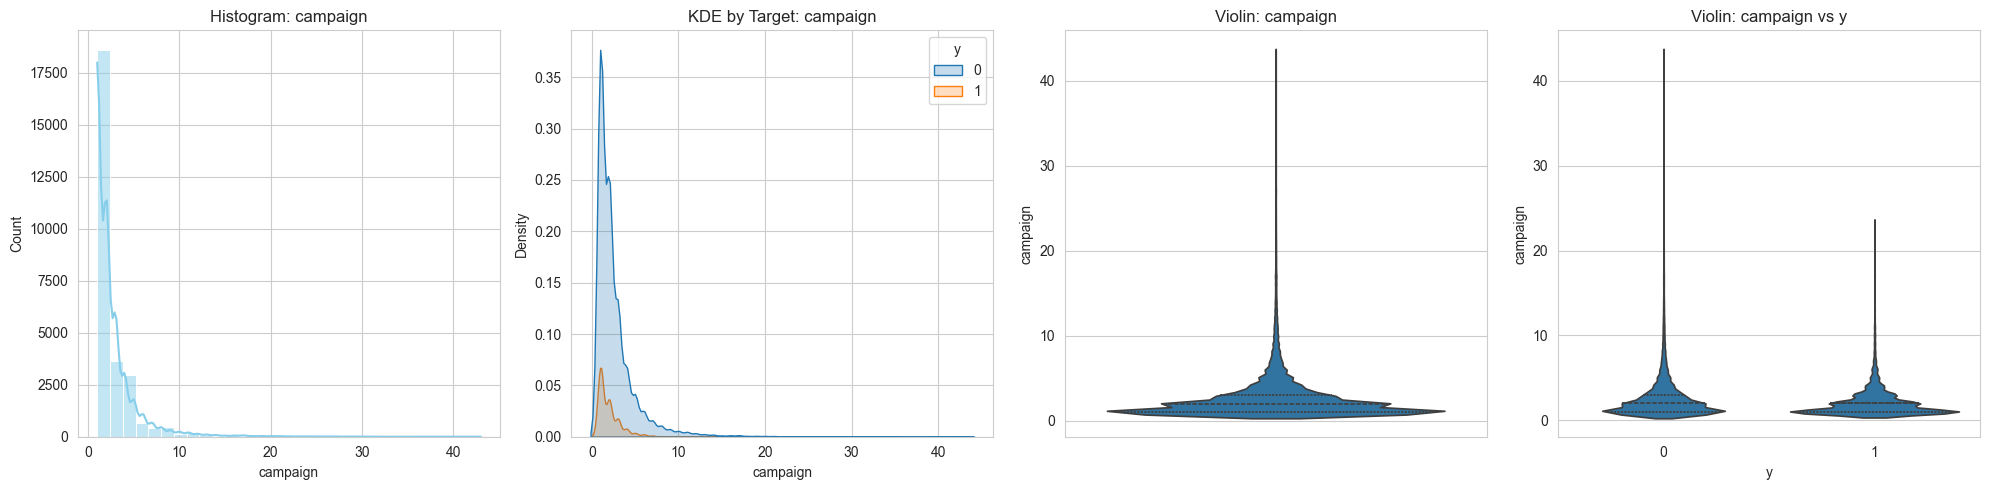

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))  # 1 row, 4 columns


# 1. Histogram
sns.histplot(X_plot['campaign'], kde=True, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title(f'Histogram: campaign')

sns.kdeplot(data=X_plot, x='campaign', hue='y', fill=True, ax=axes[1])
axes[1].set_title(f'KDE by Target: campaign')

sns.violinplot(y='campaign',data=X_plot,inner="quart", ax=axes[2])
axes[2].set_title(f'Violin: campaign')

sns.violinplot(x='y', y='campaign', data=X_plot, inner="quart", ax=axes[3])
axes[3].set_title(f"Violin: campaign vs y")

plt.tight_layout()
plt.show()



#### difining binning using visualizations

In [10]:
# 1. Define bins and labels
bins = [0 , 4 , 11, X_plot['campaign'].max()]
labels = ['1-4', '5-11', '11+']


# 2. Create the categorical age groups
campaign_group = pd.cut(
    X_plot['campaign'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# Group by campaign and target 'y'
result = X_plot.groupby([campaign_group, 'y']).size().unstack(fill_value=0)

# Add a total column
result['Total'] = result.sum(axis=1)

# # Sort by campaign value
# result = result.sort_index()

# Calculate ratios of 'yes'
result['yes_ratio'] = result[1] / result['Total']

print(result)

y             0     1  Total  yes_ratio
campaign                               
1-4       21130  3002  24132   0.124399
5-11       2763   204   2967   0.068756
11+         470    13    483   0.026915


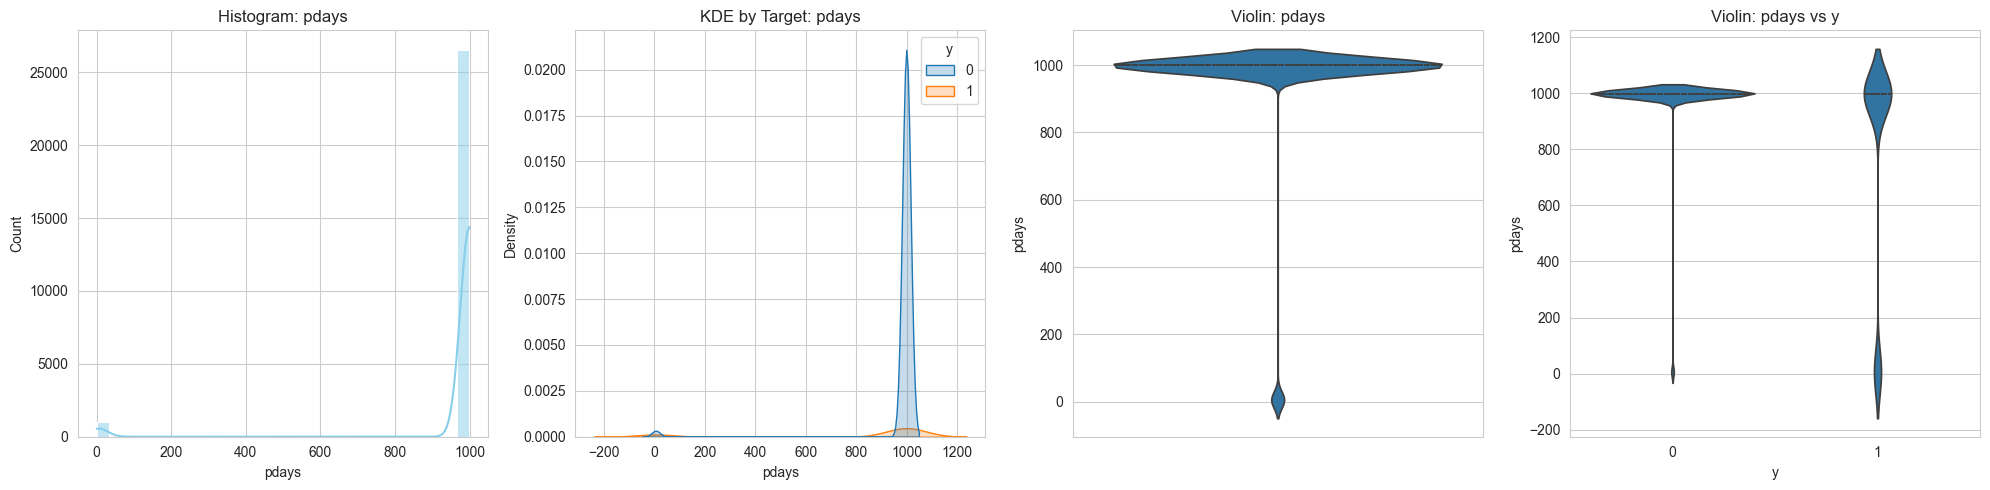

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))  # 1 row, 4 columns
# 1. Histogram
sns.histplot(X_plot['pdays'], kde=True, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title(f'Histogram: pdays')

sns.kdeplot(data=X_plot, x='pdays', hue='y', fill=True, ax=axes[1])
axes[1].set_title(f'KDE by Target: pdays')

sns.violinplot(y='pdays',data=X_plot,inner="quart", ax=axes[2])
axes[2].set_title(f'Violin: pdays')

sns.violinplot(x='y', y='pdays', data=X_plot, inner="quart", ax=axes[3])
axes[3].set_title(f"Violin: pdays vs y")

plt.tight_layout()
plt.show()



#### difining binning using visualizations

In [12]:
previous_contect_group = X_plot['pdays'].apply(lambda x: 'first_time' if x == 999 else 'more_than_once')

# Group by campaign and target 'y'
result = X_plot.groupby([previous_contect_group, 'y']).size().unstack(fill_value=0)

# Add a total column
result['Total'] = result.sum(axis=1)


# Calculate ratios of 'yes'
result['yes_ratio'] = result[1] / result['Total']

print(result)


y                   0     1  Total  yes_ratio
pdays                                        
first_time      23977  2562  26539   0.096537
more_than_once    386   657   1043   0.629914


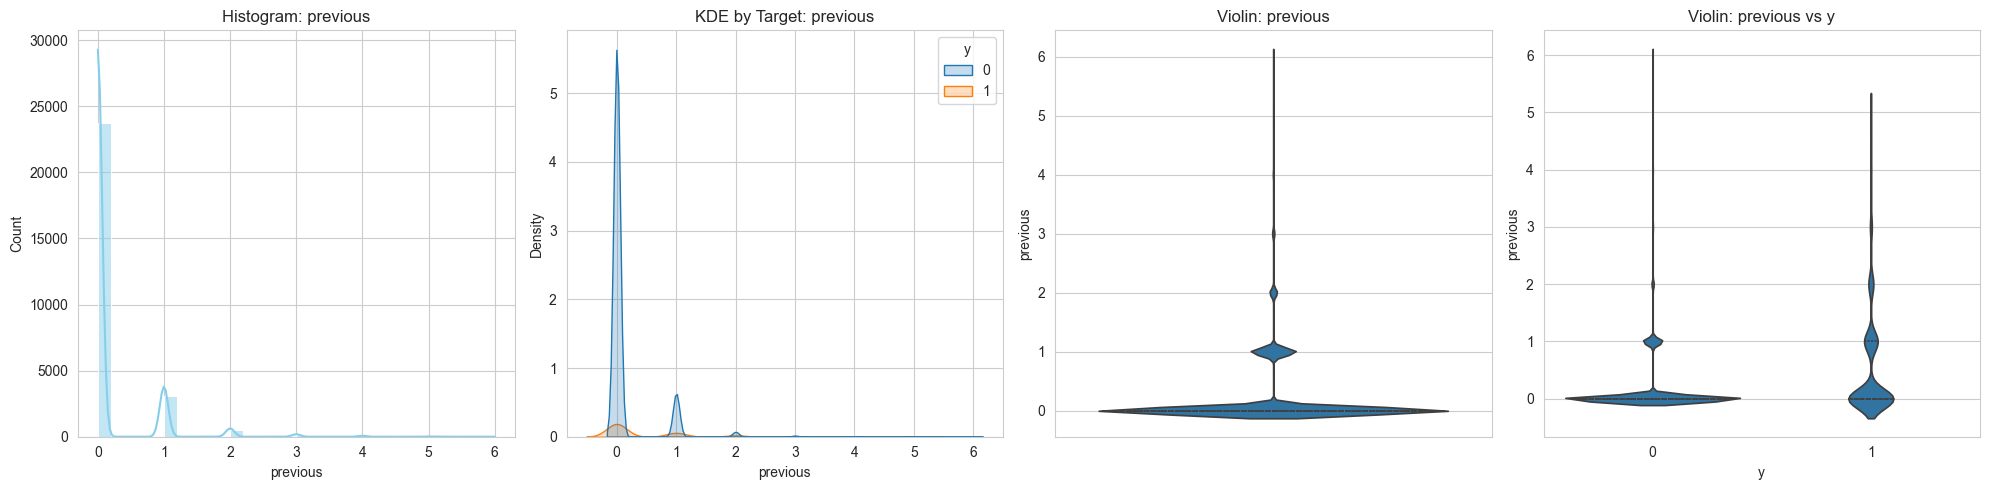

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20,5))  # 1 row, 4 columns
# 1. Histogram
sns.histplot(X_plot['previous'], kde=True, bins=30, color='skyblue', ax=axes[0])
axes[0].set_title(f'Histogram: previous')

sns.kdeplot(data=X_plot, x='previous', hue='y', fill=True, ax=axes[1])
axes[1].set_title(f'KDE by Target: previous')

sns.violinplot(y='previous',data=X_plot,inner="quart", ax=axes[2])
axes[2].set_title(f'Violin: previous')

sns.violinplot(x='y', y='previous', data=X_plot, inner="quart", ax=axes[3])
axes[3].set_title(f"Violin: previous vs y")

plt.tight_layout()
plt.show()



#### difining binning using visualizations

In [14]:
# previous_contect_be_group = X_plot['pdays'].apply(lambda x: 'first_time' if x == 999 else 'more_than_once')
p_cont = X_plot['previous'].apply(
    lambda x: 'not contected' if x == 0 else ('once contected' if x == 1 else 'more than once' )
)

# Group by campaign and target 'y'
result = X_plot.groupby([p_cont, 'y']).size().unstack(fill_value=0)

# Add a total column
result['Total'] = result.sum(axis=1)

# # Sort by campaign value
# result = result.sort_index()

# Calculate ratios of 'yes'
result['yes_ratio'] = result[1] / result['Total']

print(result)

y                   0     1  Total  yes_ratio
previous                                     
more than once    368   366    734   0.498638
not contected   21572  2193  23765   0.092279
once contected   2423   660   3083   0.214077


#### Custom Transformer for Binning

In [15]:

class CustomBinner(BaseEstimator, TransformerMixin):
    def __init__(self):
        # store bin rules
        self.age_bins = [0, 20, 28, 60, np.inf]
        self.age_labels = ['0-20', '21-28', '29-60', '61+']

        self.campaign_bins = [0, 4, 11, np.inf]
        self.campaign_labels = ['1-4', '5-11', '11+']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Age binning
        X['age'] = pd.cut(
            X['age'],
            bins=self.age_bins,
            labels=self.age_labels,
            include_lowest=True,
            right=True
        )

        # Campaign binning
        X['campaign'] = pd.cut(
            X['campaign'],
            bins=self.campaign_bins,
            labels=self.campaign_labels,
            include_lowest=True,
            right=True
        )

        # pdays binning
        X['pdays'] = X['pdays'].apply(
            lambda x: 'first_time' if x == 999 else 'more_than_once'
        )

        # previous binning
        X['previous'] = X['previous'].apply(
            lambda x: 'not contected' if x == 0 else ('once contected' if x == 1 else 'more than once')
        )

        # Handle potential NaNs created by binning (e.g., values outside bins if include_lowest=False)
        # Fill NaNs in binned columns with a placeholder
        for col in ['age', 'campaign', 'pdays', 'previous']:
             if X[col].isnull().any():
                X[col] = X[col].cat.add_categories('Unknown').fillna('Unknown')


        return X

#### Build Preprocessor Pipeline

In [16]:
# Numeric and categorical columns BEFORE binning
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Some columns (age, campaign, pdays, previous) become categorical after binning
binned_cols = ['age', 'campaign', 'pdays', 'previous']

# Update column lists
num_cols = [c for c in num_cols if c not in binned_cols]
cat_cols = list(set(cat_cols) | set(binned_cols))

preprocessor = ImbPipeline(steps=[
    ('binning', CustomBinner()),  # apply custom binning first
    ('col_transform', ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_cols)
    ]))
])

# Define a dictionary of models to evaluate
models = {
    # "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Random Forest": RandomForestClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    # "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    # "CatBoost": CatBoostClassifier(verbose=False, random_state=42),
    # "K-Nearest Neighbors": KNeighborsClassifier(),
    # "Decision Tree": DecisionTreeClassifier(),
    # "Extra Trees": ExtraTreesClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    # "AdaBoost": AdaBoostClassifier(),
    # "Naive Bayes": GaussianNB(),
    # "SVM": SVC(probability=True),

    # # stacking ensemble (LGBMClassifier + RandomForest + XGBoost)
    # "stacking_model":StackingClassifier(
    #     estimators=[
    #         ("rf", RandomForestClassifier(random_state=42)),
    #         ("xgb", XGBClassifier(
    #             use_label_encoder=False, eval_metric='logloss',
    #             random_state=42
    #         ))
    #     ],
    #     final_estimator=LGBMClassifier(random_state=42),
    #     cv=5,
    #     n_jobs=-1
    # )

}

In [17]:
def evaluate_classification(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    return acc, prec, rec, f1, auc


In [ ]:
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("--- Running Baseline Model Evaluation with Detailed Metrics ---")
for model_name, model in models.items():
    print(f"\nTraining {model_name} with Stratified K-Fold...")

    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        # Split train/val
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # pipeline for each fold
        pipeline = ImbPipeline(steps=[
            ('binning', CustomBinner()),
            ('col_transform', ColumnTransformer([
                ('num', StandardScaler(), num_cols),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
            ])),
            ('feature_selection', SelectFromModel(
                lgb.LGBMClassifier(n_estimators=200,random_state=42),
                max_features=31,   # or median but it select different number of features for each fold , which make problems
                threshold=-np.inf  # ensure max_features is used
            )),
            ('classifier', model)
        ])

        # Fit and predict
        pipeline.fit(X_tr, y_tr)
        y_pred = pipeline.predict(X_val)
        y_proba = pipeline.predict_proba(X_val)[:, 1] if hasattr(pipeline, "predict_proba") else None

        # Metrics
        acc  = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred, zero_division=0)
        rec  = recall_score(y_val, y_pred, zero_division=0)
        f1   = f1_score(y_val, y_pred, zero_division=0)
        auc  = roc_auc_score(y_val, y_proba) if y_proba is not None else 0

        fold_metrics.append((acc, prec, rec, f1, auc))
        print(f"  Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Average across folds
    avg_acc, avg_prec, avg_rec, avg_f1, avg_auc = np.mean(fold_metrics, axis=0)
    results.append({
        "Model": model_name,
        "CV_Accuracy": avg_acc,
        "CV_Precision": avg_prec,
        "CV_Recall": avg_rec,
        "CV_F1": avg_f1,
        "CV_ROC_AUC": avg_auc
    })

    print(f"{model_name} | CV F1: {avg_f1:.4f} | CV ROC-AUC: {avg_auc:.4f}")

# Final comparison
results_df = pd.DataFrame(results).sort_values(by="CV_ROC_AUC", ascending=False)
print("\n🔹 Final Model Comparison (sorted by CV ROC-AUC):")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
print(f"\n Best baseline model type: {best_model_name}")


--- Running Baseline Model Evaluation with Detailed Metrics ---

Training LightGBM with Stratified K-Fold...
[LightGBM] [Info] Number of positive: 2575, number of negative: 19490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 22065, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116701 -> initscore=-2.024052
[LightGBM] [Info] Start training from score -2.024052
[LightGBM] [Info] Number of positive: 2575, number of negative: 19490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[Light

In [ ]:
print(f"\n--- Hyperparameter Tuning for {best_model_name} ---")

tuning_pipeline = ImbPipeline(steps=[
    ('binning', CustomBinner()),
    ('col_transform', ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), cat_cols)
    ])),
    ('feature_selection', SelectFromModel(
        lgb.LGBMClassifier(n_estimators=200,random_state=42),
        max_features=31,   # or median but it select different number of features for each fold , which make problems
        threshold=-np.inf  # ensure max_features is used
    )),
    ('classifier', model)
])

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [500, 1000, 1500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [-1, 6, 10],
    'classifier__num_leaves': [31, 63, 127],
    'classifier__min_child_samples': [10, 20, 50],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0],
    'classifier__reg_alpha': [0, 0.1, 1],
    'classifier__reg_lambda': [0, 0.1, 1]
}


# Set up the randomized search
random_search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

# Fit on the training data to find the best model
random_search.fit(X_train, y_train)

# The final, tuned model is the best estimator found by the search
final_model_pipeline = random_search.best_estimator_
print(f"\n Best parameters found: {random_search.best_params_}")


--- Hyperparameter Tuning for LightGBM ---
[LightGBM] [Info] Number of positive: 3219, number of negative: 24363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 27582, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116707 -> initscore=-2.023995
[LightGBM] [Info] Start training from score -2.023995
[LightGBM] [Info] Number of positive: 3219, number of negative: 24363
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 27582, number

In [20]:
# Get transformed feature names after preprocessor
all_features = final_model_pipeline.named_steps['col_transform'].get_feature_names_out()

if 'feature_selection' in final_model_pipeline.named_steps:
    selector = final_model_pipeline.named_steps['feature_selection']
    selected_mask = selector.get_support()
    feature_names = all_features[selected_mask]
else:
    feature_names = all_features

importances = final_model_pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(importance_df.head(10))


--- Top 10 Most Important Features ---
                  Feature  Importance
3          num__euribor3m       12744
1     num__cons.price.idx        4290
2      num__cons.conf.idx        3712
0       num__emp.var.rate        1838
21   cat__day_of_week_mon        1177
29         cat__age_29-60        1097
30  cat__poutcome_failure        1035
4        num__nr.employed        1005
8   cat__contact_cellular         973
5       cat__campaign_1-4         949


## IMPORTANT
##### Final Model Evaluation and Decision Threshold Optimization using custom business metric and precision recall curves (imbalance dataset).



--- Finding Optimal Threshold on Validation Set ---
✅ Best Threshold for Max Profit: 0.1726
💰 Best Threshold: 0.17259671750464992
Recall = 0.628, Precision = 0.452
Calls Made = 958, True Positives = 433
Max Profit = $10798.00


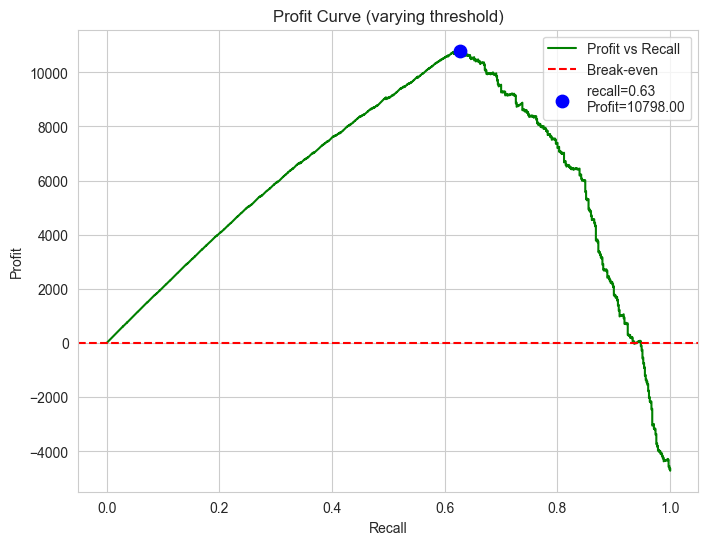

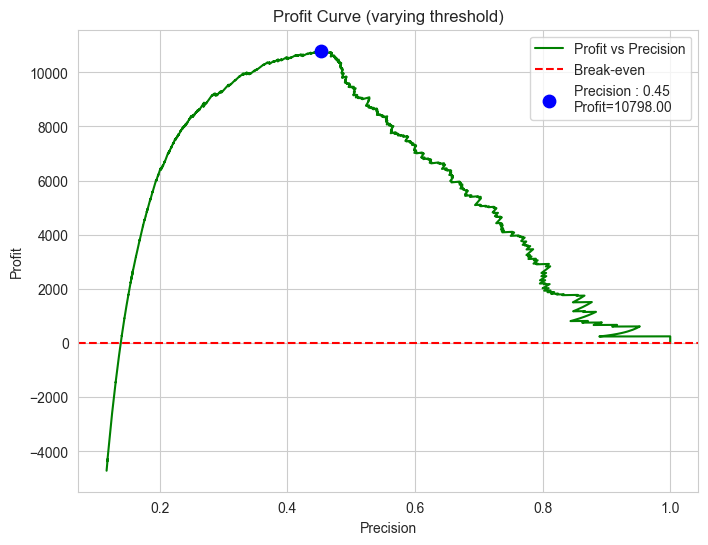

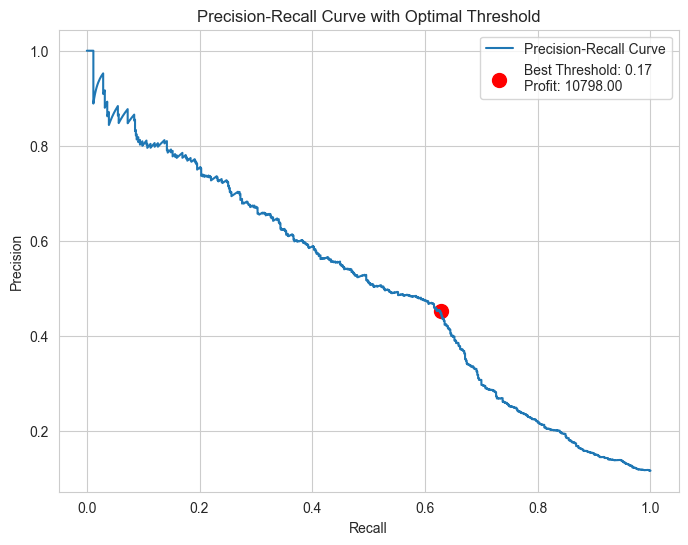

In [ ]:
print("\n--- Finding Optimal Threshold on Validation Set ---")

# Get prediction probabilities on the validation data
y_val_proba = final_model_pipeline.predict_proba(X_validate)[:, 1]

# Define business metrics

# marketing_cost per call
# Affected by TP and FP --> we make call to both , 1.actual true and predicted true , 2. actual false but predicted true)
call_cost = 5.0  # (including labor & infrastructure)

# this cost are affect after customer Acquisition (agree for subscription)(only Affected by TP-actual true and predicted true )
# Onboarding & KYC verification cost
onboarding_cost = 5
#Account management costs(back-office ops, compliance)
acc_cost = 15
# Other overheads(like customer support): 
other_overheads = 10
total_customer_cost = onboarding_cost + acc_cost + other_overheads  # Total acquisition cost

# calculating revenue per costomer (only Affected by TP-actual true and predicted true )
# Average deposit amount = 4000
# Interest spread(Interest Earned by Bank on Loans or Investments − Interest Paid to Customer on Deposit) = 2.2% annually
# Customer holds deposit for 1 year
subscription_revenue = 88 # (4000 * 0.022)

# Calculate profit for every possible threshold 
precisions, recalls, thresholds = precision_recall_curve(y_validate, y_val_proba)

# To avoid division by zero
valid_precisions = np.maximum(precisions, 1e-8)
calls_made = (recalls * sum(y_validate)) / valid_precisions
#total profit = total_revenue - total_cost(cost of handling + marketing)
profit = (recalls * sum(y_validate) * subscription_revenue) - (recalls * sum(y_validate) * total_customer_cost) - (calls_made * call_cost)


# Find the threshold that corresponds to the maximum profit
best_threshold = thresholds[np.argmax(profit)]
print(f" Best Threshold for Max Profit: {best_threshold:.4f}")


# True positives and predicted positives at each point
total_pos = sum(y_validate)
TP = recalls * total_pos
pred_pos = np.divide(TP, np.maximum(precisions, 1e-8))  # calls made

# === Find Best Point ===
best_idx = np.argmax(profit)
print(f" Best Threshold: {best_threshold}")
print(f"Recall = {recalls[best_idx]:.3f}, Precision = {precisions[best_idx]:.3f}")
print(f"Calls Made = {int(pred_pos[best_idx])}, True Positives = {int(TP[best_idx])}")
print(f"Max Profit = ${profit[best_idx]:.2f}")

# Find index of max profit for point of curves
max_idx = np.argmax(profit)
max_recall = recalls[max_idx]
max_precision = precisions[max_idx]
max_profit = profit[max_idx]

# === Profit Curve ===
plt.figure(figsize=(8,6))
plt.plot(recalls, profit, label="Profit vs Recall", color="green")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.scatter(max_recall, max_profit, color="blue", s=80, zorder=5, 
            label=f"recall={max_recall:.2f} \nProfit={max_profit:.2f}")
plt.xlabel("Recall")
plt.ylabel("Profit")
plt.title("Profit Curve (varying threshold)")
plt.grid(True)
plt.legend()
plt.show()


# Plot
plt.figure(figsize=(8,6))
plt.plot(precisions, profit, label="Profit vs Precision", color="green")
plt.axhline(0, color="red", linestyle="--", label="Break-even")
plt.scatter(max_precision, max_profit, color="blue", s=80, zorder=5, 
            label=f"Precision : {max_precision:.2f} \nProfit={max_profit:.2f}")
plt.xlabel("Precision")
plt.ylabel("Profit")
plt.title("Profit Curve (varying threshold)")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=100,
            label=f"Best Threshold: {best_threshold:.2f}\nProfit: {max_profit:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Make predictions on the TEST set
y_test_proba = final_model_pipeline.predict_proba(X_test)[:, 1]

# Apply the threshold found on the validation set to get final class predictions
y_test_pred_optimized = (y_test_proba >= best_threshold).astype(int)

print(f"\n--- 🏁 Final Report on Test Set (Threshold = {best_threshold:.4f}) ---")
print(classification_report(y_test, y_test_pred_optimized, target_names=['No Subscription', 'Subscription']))




--- 🏁 Final Report on Test Set (Threshold = 0.1726) ---
                 precision    recall  f1-score   support

No Subscription       0.94      0.90      0.92      5222
   Subscription       0.43      0.59      0.49       689

       accuracy                           0.86      5911
      macro avg       0.68      0.74      0.71      5911
   weighted avg       0.88      0.86      0.87      5911



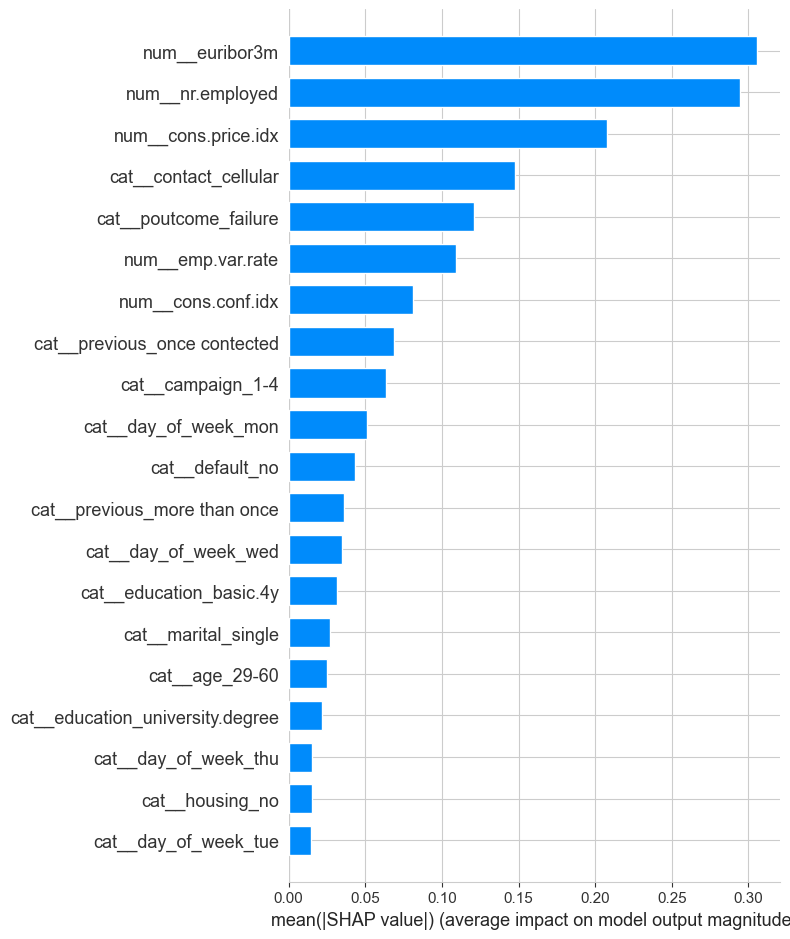

In [23]:
# Apply custom binning first
X_test_binned = final_model_pipeline.named_steps['binning'].transform(X_test)

# Full preprocessing (excluding the binning step which was done manually for inspection)
# This part of the pipeline should now receive the X_test_binned data
col_transformer = final_model_pipeline.named_steps['col_transform']
X_test_preprocessed = col_transformer.transform(X_test_binned)

# Apply feature selection
selector = final_model_pipeline.named_steps['feature_selection']
X_test_processed = selector.transform(X_test_preprocessed)

# Correct feature names
# Try to get feature names by fitting a temporary pipeline on the training data
temp_pipeline = ImbPipeline(steps=[
    ('binning', CustomBinner()),
    ('col_transform', ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]))
])

temp_pipeline.fit(X_train, y_train) 
all_features_train = temp_pipeline.named_steps['col_transform'].get_feature_names_out()
feature_names = all_features_train[selector.get_support()]


# Create DataFrame for SHAP
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# SHAP explanation
explainer = shap.TreeExplainer(final_model_pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_processed_df)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar")